![跟踪器](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&file=Vertex+AI+AutoML+Forecasting+-+Python+client.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/Vertex%20AI%20AutoML%20Forecasting%20-%20Python%20client.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>在<br>Colab中运行
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520Forecasting%2FVertex%2520AI%2520AutoML%2520Forecasting%2520-%2520Python%2520client.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>在<br>Colab Enterprise中运行
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/Vertex%20AI%20AutoML%20Forecasting%20-%20Python%20client.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>在<br>GitHub上查看
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20Forecasting/Vertex%20AI%20AutoML%20Forecasting%20-%20Python%20client.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>在<br>Vertex AI Workbench中打开
    </a>
  </td>
</table>

# Vertex AI AutoML Forecasting - Python客户端

在这本笔记本中，我们将对在[准备笔记本](./BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb)中检查和准备的数据进行预测模型拟合 - 纽约市中央公园附近的Citibike自行车租赁站每日租赁量。在这次尝试中，预测将使用[Vertex AI](https://cloud.google.com/vertex-ai/docs/start/introduction-unified-platform)管理的预测服务完成：[Vertex AI预测](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/overview)。该服务包括用于神经网络模型类型的训练：
- [AutoML](./Vertex%20AI%20AutoML%20Forecasting%20-%20Python%20client.ipynb) (**本笔记本**)
    - 适用于各种用例
    - 博客：[使用AutoML进行时间序列预测](https://ai.googleblog.com/2020/12/using-automl-for-time-series-forecasting.html)
- [Seq2Seq+](./Vertex%20AI%20Seq2Seq+%20Forecasting%20-%20Python%20client.ipynb)
    - 具有较小搜索空间的简单架构。适用于实验和较小的数据集以及较小的时间预算。
- [时间融合转换器 (TFT)](./Vertex%20AI%20Temporal%20Fusion%20Transformer%20Forecasting%20-%20Python%20client.ipynb)
    - 基于注意力的高准确性和可解释性深度神经网络。
    - 博客：[可解释的时间序列预测深度学习](https://ai.googleblog.com/2021/12/interpretable-deep-learning-for-time.html)
    - 研究论文：[用于可解释的多时域时间序列预测的时间融合转换器](https://www.sciencedirect.com/science/article/pii/S0169207021000637)
- [时间序列Dense编码器（TiDE）](./Vertex%20AI%20Time%20series%20Dense%20Encoder%20-%20Python%20client.ipynb)
    - 优化的基于密集DNN的编码器-解码器模型。适合用于快速训练和推断，有助于长上下文和时间跨度。
    - 博客：[深度长时距预测的最新进展 - Google AI博客](https://ai.googleblog.com/2023/04/recent-advances-in-deep-long-horizon.html)
    - 研究论文：[使用TiDE进行长期预测：时间序列密集编码器](https://arxiv.org/abs/2304.08424)

**注意:**
>此笔记本使用[Vertex AI Python SDK](https://cloud.google.com/python/docs/reference/aiplatform/latest)。此处使用的Python客户端的方法与[Vertex AI AutoML预测 - GCP控制台（无代码）](./Vertex%20AI%20AutoML%20Forecasting%20-%20GCP%20Console%20(no%20code).ipynb)笔记本中使用的方法匹配，该笔记本展示了使用Google Cloud控制台（无代码）的工作流程。在模型规范中更改的一个参数是上下文窗口，这里设置为28，在以前的笔记本中设置为14。这些上下文窗口与笔记本[Vertex AI AutoML预测 - 同时多个](./Vertex%20AI%20AutoML%20Forecasting%20-%20multiple%20simultaneously.ipynb)中的其他上下文窗口进行比较。

Vertex AI预测方法允许用户通过指定其数据源、描述数据的参数以及训练时间（以小时为单位）来创建准确和可扩展的预测。源数据和输出数据可以是存储在GCS存储桶或BigQuery表中的文件。这些预测方法处理了可能描述数据形状的许多因素，如：
- [分层预测](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/hierarchical)，包括组和时间。例如：产品所属类别（组）内的产品和/或每日销售额汇总到周级别（时间）。
- 改变训练行的重要性的[权重](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/prepare-data#weight)。例如：可以将更高的权重应用于在校准后立即进行测量的制造线上，直到下一次校准为止。
- 用于指定数据聚集级别的[粒度](https://cloud.google.com/vertex-ai/docs/tabular-data/bp-tabular#granularity)，用于验证数据（时间点的多次测量）并处理缺失的时间点。在处理分钟级别的粒度时，还可以指定测量之间的数量，如1、5、10、15或30分钟。
- 一个或多个地区和/或个别国家的假期
- [预测窗口](https://cloud.google.com/vertex-ai/docs/tabular-data/bp-tabular#context-window)包括：
    - 预测时间跨度，即向未来预测多远
    - 上下文窗口，即模型查找影响时间点的模式的时间范围
    - 使用自定义[窗口策略](https://cloud.google.com/vertex-ai/docs/tabular-data/bp-tabular#rolling_window_strategies)控制窗口的数量和频率
        - 计数 - 设置窗口的数量
        - 步幅 - 设置窗口之间的间隔。对于每日预测使用7，每周只生成一个星期的预测。
        - 列 - 提供True/False值的列，以确定用于生成窗口的哪些行
- [优化目标](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/train-model#optimization-objectives)可以选择以量身定制预测，在可能存在极端值或范围独特高/低的情景中。
- [指定特征](https://cloud.google.com/vertex-ai/docs/datasets/data-types-tabular#feature-type)（属性和协变量）：
    - 描述时间序列的属性
    - 已知的提前时间变化的协变量，如节假日、促销、计划的交付
    - 不知道提前时间变化的协变量，如天气、交通、停机时间
- [转换特性](https://cloud.google.com/vertex-ai/docs/datasets/data-types-tabular#transformations)，如对文本字符串进行标记化
- 通过提供拆分数据的[数据拆分](https://cloud.google.com/vertex-ai/docs/tabular-data/data-splits#forecasting)列来控制将数据拆分为训练、验证和测试集，并使用时间顺序控制拆分参数

---

**系列概览**

[该系列](./readme.md)探讨了使用Vertex AI、BigQuery ML和其他开源框架进行预测。预测包括随着时间的推移跟踪测量并探索趋势、季节性的影响（年、月、日等）、假期以及特殊事件的影响，希望利用这些见解对接近未来进行预测。一些方法还会包含影响需求的可观测测量，以了解关系并使预测更准确。

**数据源：纽约市Citibike租赁**

本系列使用纽约市Citibike租赁数据。将选择靠近中央公园的自行车站，并跟踪这些站点起始的每日自行车行程数量。这将说明由于经过时间引入了新站点，并且一些站点只有最近几个月或几周的数据，所以存在一些常见的预测问题。数据可在BigQuery公共数据集中找到：
- `bigquery-public-data.new_york.citibike_trips`
- `bigquery-public-data.new_york.citibike_stations`

**Vertex AI概述**

[Vertex AI](https://cloud.google.com/vertex-ai/docs/start/introduction-unified-platform)是一个用于[训练](https://cloud.google.com/vertex-ai/docs/training-overview)、[评估](https://cloud.google.com/vertex-ai/docs/evaluation/introduction)、[部署](https://cloud.google.com/vertex-ai/docs/predictions/overview)和[监控](https://cloud.google.com/vertex-ai/docs/model-monitoring)ML模型的机器学习平台。它具有用于[Vertex AI Workbench](https://cloud.google.com/vertex-ai/docs/workbench/introduction)的探索工具，以及用于工作流程和自动化的[Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction)的工具。

Vertex AI通过许多特定用途的投入加强了这种流程。例如
- 管理模型
    - 包括具有版本控制的[Vertex AI模型注册表](https://cloud.google.com/vertex-ai/docs/model-registry/introduction)
    - 使用[Vertex AI可解释AI](https://cloud.google.com/vertex-ai/docs/explainable-ai/overview)（包括基于特征和示例的解释）了解模型
- 更好的训练
    - [预建的训练容器](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers)适用于许多常见框架，自动处理GPU设置、挂载GCS以检索文件，甚至与NFS挂载一起使用
    - 管理[Vertex AI Tensorboard](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview)，提供持久的实时模型训练视图，用于在整个Vertex AI上进行跟踪
    - 具有[自动度量记录](https://cloud.google.com/vertex-ai/docs/experiments/autolog-data)的[实验跟踪](https://cloud.google.com/vertex-ai/docs/experiments/intro-vertex-ai-experiments) 
    - 通过查询Vertex AI ML元数据来跟踪和分析
- 扩展训练
    - 易于配置的[分布式训练](https://cloud.google.com/vertex-ai/docs/training/distributed-training)
    - 用于加速训练的[减少服务器](https://cloud.google.com/vertex-ai/docs/training/distributed-training#reduce_training_time_with_reduction_server)
    - [超参数调整](https://cloud.google.com/vertex-ai/docs/training/hyperparameter-tuning-overview)，包括[Vertex AI Vizier](https://cloud.google.com/vertex-ai/docs/vizier/overview)
    - 使用[TPU加速器](https://cloud.google.com/vertex-ai/docs/training/training-with-tpu-vm)进行训练
- 扩展预测
    - 为多种常见框架提供[预构建服务容器](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)
    - 具有[缩放](https://cloud.google.com/vertex-ai/docs/predictions/configure-compute#scaling)和[流量分担](https://cloud.google.com/vertex-ai/docs/general/deployment#models-endpoint)的[端点](https://cloud.google.com/vertex-ai/docs/general/deployment)
    - 使用[私有端点](https://cloud.google.com/vertex-ai/docs/predictions/using-private-endpoints)进行安全和快速预测
    - 使用[共享资源在部署中共存模型](https://cloud.google.com/vertex-ai/docs/predictions/model-co-hosting)
    - 使用[自定义预测例程](https://cloud.google.com/vertex-ai/docs/predictions/custom-prediction-routines)轻松构建自定义服务容器，通过预处理和后处理扩展模型：处理输入、调用外部服务以获取额外数据、处理输出
    - [NVIDA Triton推理服务器](https://cloud.google.com/vertex-ai/docs/predictions/using-nvidia-triton)用于共同部署多个模型，甚至多个框架，具有直接访问和集成
    - [批量预测](https://cloud.google.com/vertex-ai/docs/predictions/overview#batch_predictions)
    
- 使用[Vertex AI Feature Store](https://cloud.google.com/vertex-ai/docs/featurestore/overview)进行特性管理
- 使用低延迟向量数据库[Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview)提供快速、可扩展的最近邻服务
- 通过在[KFP和TFX管线运行](https://cloud.google.com/vertex-ai/docs/pipelines/introduction)具有服务器后端的高度可配置工作流程，并包括[GCP（如Dataproc和Dataflow）](https://cloud.google.com/vertex-ai/docs/pipelines/gcpc-list#dataproc_sl_components)和[Vertex AI](https://cloud.google.com/vertex-ai/docs/pipelines/gcpc-list#vertex_ai_components)服务的[预构建组件](https://cloud.google.com/vertex-ai/docs/pipelines/components-introduction)

---

**先决条件:**
- [BigQuery时间序列预测数据审查和准备](./BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb)
    - 为此笔记准备数据

**资源:**
- [BigQuery](https://cloud.google.com/bigquery/docs/introduction)
    - [BigQuery Python客户端](https://cloud.google.com/python/docs/reference/bigquery/latest)
    - [SQL参考](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)
- [Vertex AI](https://cloud.google.com/vertex-ai/docs/start/introduction-unified-platform)
    - [Vertex AI Python SDK](https://cloud.google.com/python/docs/reference/aiplatform/latest)
    - [Vertex AI AutoML预测](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/train-model#api)

### 概念流和工作流程
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/afore4_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/afore4_console.png" width="45%">
</p>

# Colab设置

要在Colab中运行此笔记本，请点击 [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/Vertex%20AI%20AutoML%20Forecasting%20-%20Python%20client.ipynb) 并运行本节中的单元格。否则，请跳过本节。

此单元格将对GCP进行身份验证（请按弹出窗口中的提示操作）。

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [473]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

安装

输入：

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [8]:
REGION = 'us-central1'
EXPERIMENT = 'automl-python'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-data_prepped'

viz_limit = 12

包裹:

In [6]:
from google.cloud import aiplatform
from google.cloud import bigquery

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

客户:

In [7]:
bq = bigquery.Client(project=PROJECT_ID)
aiplatform.init(project=PROJECT_ID, location=REGION)

参数:

In [38]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

## 时间序列回顾

**单变量预测**由每个时间序列的2列组成：
- `TARGET_COLUMN` = 需求测量。
    在我们的案例中，这是每天从特定自行车站出发的旅行次数 - 每天的旅行总和。
- `TIME_COLUMN` = 需求的时间。
    以与预测练习的粒度相关的时间或日期单位表示。在我们的案例中，需求是每天测量的，因此时间列被准备成日期。

**附加列**用于指导预测算法处理数据：
- `SERIES_COLUMN`将与同一时间序列相关的行分组。
    - 进行多个预测，每个时间序列一个，意味着包括第三列来捕获每个时间序列的行的组别：`SERIES_COLUMN`。
    - **注意:** BigQuery ARIMA+为每个时间序列拟合单独的预测。
- `SPLITS_COLUMN`将每个时间序列内部的连续行分组，以便在预测练习中使用。
    - 这些数据已经在先决笔记本中准备好了`TRAIN`，`VALIDATE`和`TEST`的拆分。包含这些拆分的列可以在训练期间由所选的预测方法使用，而不是让方法计算拆分。在比较多种不同方法时，这可能会有所帮助，因为它确保拆分在每种方法中处理方式相同。
- `COVARIATE_COLUMNS`是列的列表，这些列测量随时间推移的其他特征。一些预测方法可以使用这些特征来改善趋势的理解并做出更好的预测。单变量预测方法将不使用这些列。要将一种协变量用于预测，其值需要事先知道，以便在进行预测时使用，或者预测方法将需要对未知协变量进行特殊处理。三种协变量信息是：
    - 属性
        - 不随时间变化但描述时间序列代表的内容的值。在我们的案例中，自行车站可以通过纬度和经度、颜色、自行车位数量来识别。
    - 可用（已知）于预测时间的协变量
        - 这些是可以事先知晓的测量，比如假期发生时间、促销活动、事件、容量变化。
    - 预测时间不可用（未知）的协变量
        - 随时间变化但直到测量时间才知晓的测量，比如雨量、其他天气、人流量和队列长度。

**预测参数**：
- `FORECAST_GRANULARITY`是测量频率，如MINUTE，HOUR，DAY，WEEK，MONTH，YEAR
    - 数据在准备数据笔记本中以DAY级别进行了汇总。
    - 这是测量之间的时间间隔 - 行
    - 对于不同的粒度，您可能需要将需求信号的汇总作为`SUM`，`MIN`，`MAX`或`AVERAGE`，适用于不同的时间组件。
    - 粒度规范因方法而异：
        - BigQuery ML: PER_MINUTE，HOURLY，DAILY，WEEKLY，MONTHLY，QUARTERLY，YEARLY
        - Prophet（包括Vertex预置管道）：minute，hour，day，week，month或year
        - Vertex AI AutoML：minute，hour，day，week，month，year
    - 一个非常有帮助的BigQuery函数，用于提取时间和日期的组件是`EXTRACT`函数：
        - [日期函数中的提取](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#extract)
        - [时间函数中的提取](https://cloud.google.com/bigquery/docs/reference/standard-sql/time_functions#extract)
        - [日期时间函数中的提取](https://cloud.google.com/bigquery/docs/reference/standard-sql/datetime_functions#extract)。
- `FORECAST_TEST_LENGTH`是分配给测试区域的行数
    - 这是以`FORECAST_GRANULARITY`为单位的。
    - 数据准备包括为每个时间序列在`SERIES_COLUMN`中指定`SPLITS_COLUMN = 'TEST'`值。
- `FORCAST_VALIDATE_LENGTH`是分配给验证区域的行数
    - 这是以`FORECAST_GRANULARITY`为单位的。
    - 数据准备包括为每个时间序列在`SERIES_COLUMN`中指定`SPLITS_COLUMN = 'VALIDATE'`值。
- `FORECAST_HORIZON_LENGTH`是预测未来超出测试区域的行数
    - 这是以`FORECAST_GRANULARITY`为单位的。
    - 这需要作为预测方法的输入来设置。

In [10]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
SPLIT_COLUMN = 'splits'
#COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty
COVARIATE_COLUMNS_ATTRIBUTES = []
COVARIATE_COLUMNS_KNOWN = ['capacity']
COVARIATE_COLUMNS_UNKNOWN = ['avg_tripduration', 'pct_subscriber', 'ratio_gender']

# CUSTOMIZE
FORECAST_GRANULARITY = 'DAY' # the data preparation included preparing the data at this level
FORECAST_HORIZON_LENGTH = 14
FORECAST_TEST_LENGTH = 14 # the data preparation included setting this value for splits = TEST
FORECAST_VALIDATE_LENGTH = 14 # the data preparation included setting this value for splits = VALIDATE

检索拆分的关键日期。

In [11]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            GROUP BY {SPLIT_COLUMN}
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

检索原始数据：

In [12]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {SPLIT_COLUMN}, {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

### 绘制时间序列

使用[Plotly](https://plotly.com/python/)创建一个交互式图表，用于查看各个时间序列（自行车站）并通过滚动时间范围进行浏览。

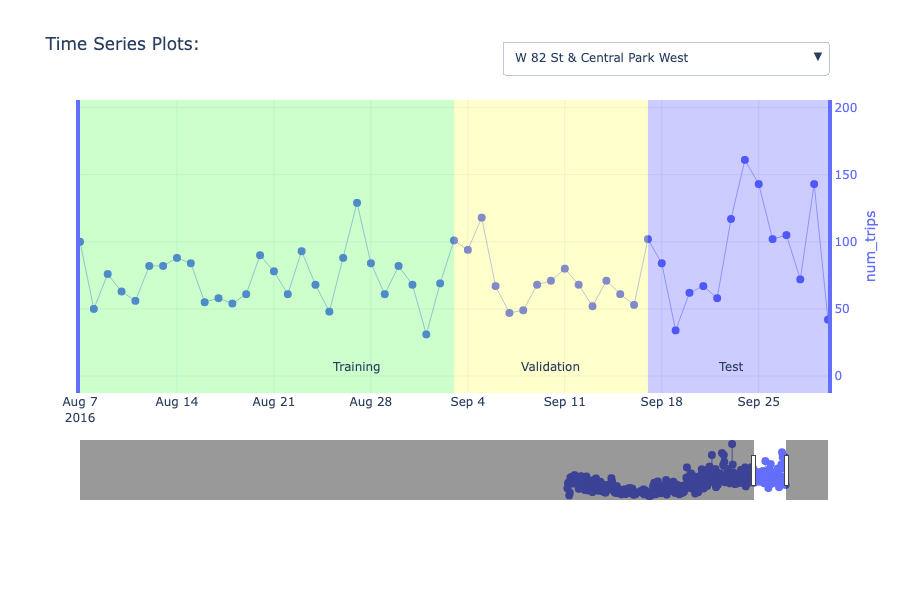

In [84]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] # + COVARIATE_COLUMNS # no covariate for univarate forecasting

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
    
    # which button to show:
    ff = 0 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

A Snapshot of the interactive plot:


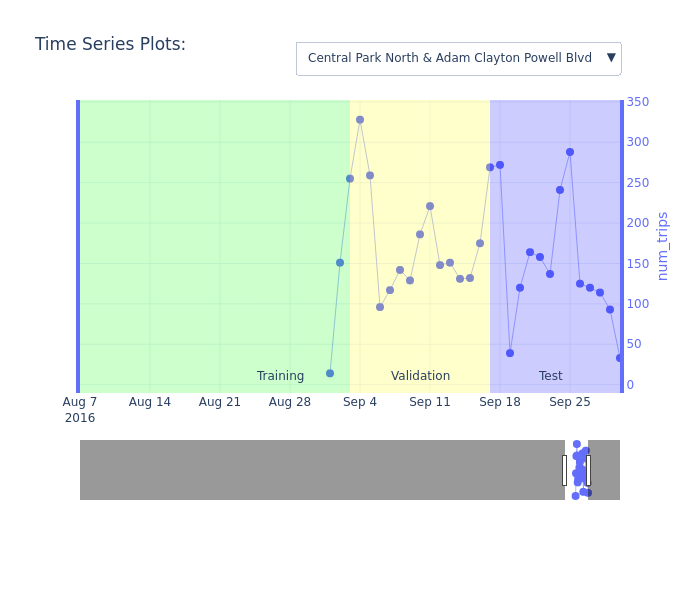

In [14]:
print('A Snapshot of the interactive plot:')
fig.show('png')

创建预测模型

Vertex AI预测方法允许用户通过指定数据源、描述数据的参数和训练时间（以小时计）来创建准确且可伸缩的预测模型。源数据和输出数据可以是存储在GCS存储桶或BigQuery表中的文件。这些预测方法处理许多可能描述数据形状的因素，如：
- 层次预测，包括组和时间。例如：产品在类别（组）内以及/或每日销售总结为每周（时间）。
- 改变训练行重要性的[权重](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/prepare-data#weight)。例如：对标定后的制造线上的测量进行较高权重的设置，然后随着时间减小至下一次标定。
- [粒度](https://cloud.google.com/vertex-ai/docs/tabular-data/bp-tabular#granularity)用于指定数据的聚合级别，并用于验证数据（时间点的多次测量）和处理缺失时间点。使用分钟级粒度时，还可以指定测量之间的间隔，如1、5、10、15或30分钟。
- 一个或多个区域和/或单个国家的节假日
- 由以下组成的[预测窗口](https://cloud.google.com/vertex-ai/docs/tabular-data/bp-tabular#context-window)：
    - 预测视野，即预测未来多远
    - 上下文窗口，即模型查找影响时间点模式的历史时间范围
    - 使用自定义[窗口策略](https://cloud.google.com/vertex-ai/docs/tabular-data/bp-tabular#rolling_window_strategies)控制窗口数量和频率：
        - 计数-设置窗口数量
        - 步幅-设置窗口之间的间隔。对于每日预测，使用7将每周仅创建一天的预测。
        - 列-提供一列True/False值，确定哪些行用于生成窗口
- 可以选择[优化目标](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/train-model#optimization-objectives)，以调整在极端值可能存在或范围独特高/低的情景下进行预测。
- [指定特征](https://cloud.google.com/vertex-ai/docs/datasets/data-types-tabular#feature-type)（属性和协变量）：
    - 描述时间序列的属性
    - 预先已知的时间变化的协变量，如假日、促销、计划交付
    - 未知的时间变化的协变量，如天气、交通、停机时间
- [转换特征](https://cloud.google.com/vertex-ai/docs/datasets/data-types-tabular#transformations)如词元化文本字符串
- 通过提供具有分割或参数控制训练、验证和测试数据集的分割的列来[分割](https://cloud.google.com/vertex-ai/docs/tabular-data/data-splits#forecasting)数据，按照时间顺序进行分割。

### 创建数据集（链接到BigQuery表）

Vertex AI数据集是Vertex AI预测作业（AutoML，Seq2Seq，TFT）的输入。这创建了Vertex AI与外部数据之间的链接，而不会从其源头复制数据。对源数据进行的更改将应用于所有从更改时间开始训练的模型。

资源：
- 有关预测数据集的[文档](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/create-dataset)
- Python SDK参考[aiplatform.TimeSeriesDataset.create()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.TimeSeriesDataset#google_cloud_aiplatform_TimeSeriesDataset_create)

In [31]:
if SERIES in [ds.display_name for ds in aiplatform.TimeSeriesDataset.list()]:
    dataset = aiplatform.TimeSeriesDataset.list(filter = f'display_name={SERIES}')[0]
else:
    dataset = aiplatform.TimeSeriesDataset.create(
        display_name = f'{SERIES}', 
        bq_source = f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}',
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
    )

print(f'Created/Retrieve Dataset: {dataset.display_name}')

Created/Retrieve Dataset: applied-forecasting


In [33]:
dataset.column_names

['ratio_gender',
 'pct_subscriber',
 'splits',
 'starttime',
 'start_station_name',
 'capacity',
 'avg_tripduration',
 'num_trips']

### 使用Vertex AI AutoML训练预测模型

#### 模型注册工作

Vertex AI 预测作业（AutoML、Seq2Seq、TFT）的结果是在 Vertex AI 模型注册中的一个模型。这些模型具有版本控制，因此如果此笔记本之前已运行过，我们可以将新的运行添加为相同模型注册中的新版本。为此，首先我们检查模型注册，查找来自此笔记本的现有模型（使用 `SERIES` 和 `EXPERIMENT` 参数）。

In [39]:
modelmatch = aiplatform.Model.list(filter = f'display_name={SERIES}_{EXPERIMENT} AND labels.series={SERIES} AND labels.experiment={EXPERIMENT}')

if modelmatch:
    print("There is an existing model with versions: ", [f'{m.version_id}' for m in modelmatch])
    parent = modelmatch[0].resource_name
else:
    print("This is the first training for this model")
    parent = ''

This is the first training for this model


#### 创建AutoML预测作业

通过设置参数创建一个AutoML预测作业。

资源：
- [预测作业的文档](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/train-model#train_a_model)
- Python SDK参考 [aiplatform.AutoMLForecastingTrainingJob()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.AutoMLForecastingTrainingJob)

首先，对于在模型中使用的列，将它们的规格设置为“auto”。省略用于拆分数据和识别时间系列的列：

In [40]:
column_specs = dict.fromkeys(
    list(
        set(dataset.column_names) - set([SPLIT_COLUMN, SERIES_COLUMN])
    ),
    'auto'
)
column_specs

{'ratio_gender': 'auto',
 'pct_subscriber': 'auto',
 'starttime': 'auto',
 'capacity': 'auto',
 'avg_tripduration': 'auto',
 'num_trips': 'auto'}

In [41]:
forecasting_job = aiplatform.AutoMLForecastingTrainingJob(
    display_name = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}',
    optimization_objective = "minimize-rmse",
    column_specs = column_specs,
    labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
)

运行AutoML预测作业

运行作业是进行预测参数化的关键点。

[aiplatform.AutoMLForecastingTrainingJob.run()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.AutoMLForecastingTrainingJob#google_cloud_aiplatform_AutoMLForecastingTrainingJob_run)的Python SDK参考。

In [42]:
forecast = forecasting_job.run(
    # data parameters
    dataset = dataset,
    target_column = TARGET_COLUMN,
    time_column = TIME_COLUMN,
    time_series_identifier_column = SERIES_COLUMN,
    time_series_attribute_columns = COVARIATE_COLUMNS_ATTRIBUTES,
    unavailable_at_forecast_columns = [TARGET_COLUMN] + COVARIATE_COLUMNS_UNKNOWN,
    available_at_forecast_columns = [TIME_COLUMN] + COVARIATE_COLUMNS_KNOWN,
    predefined_split_column_name = SPLIT_COLUMN,
    
    # forecast parameters
    forecast_horizon = FORECAST_HORIZON_LENGTH,
    data_granularity_unit = FORECAST_GRANULARITY,
    data_granularity_count = 1,
    context_window = 28,
    holiday_regions = ['GLOBAL', 'NA', 'US'],
    
    hierarchy_group_columns = [],
    hierarchy_group_total_weight = 1.0,
    hierarchy_temporal_total_weight = 2.0,
    hierarchy_group_temporal_total_weight = 1.0,
    
    # output parameters
    export_evaluated_data_items = True,
    export_evaluated_data_items_bigquery_destination_uri = f"bq://{BQ_PROJECT}:{BQ_DATASET}:{EXPERIMENT}_eval",
    export_evaluated_data_items_override_destination = True,
    
    # running parameters
    validation_options = "fail-pipeline",
    budget_milli_node_hours = 1000,
    
    # model parameters
    model_display_name = f"{SERIES}_{EXPERIMENT}",
    model_labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'},
    model_id = f"model_{SERIES}_{EXPERIMENT}",
    parent_model = parent,
    is_default_version = True,
    
    # session parameters: False means continue in local session, True waits and logs progress
    sync = True
)

View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/3842173426835914752?project=1026793852137


INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/3842173426835914752?project=1026793852137


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLForecastingTrainingJob run completed. Resource name: projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752


INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob run completed. Resource name: projects/1026793852137/locations/us-central1/trainingPipelines/3842173426835914752


Model available at projects/1026793852137/locations/us-central1/models/model_applied-forecasting_automl-python


INFO:google.cloud.aiplatform.training_jobs:Model available at projects/1026793852137/locations/us-central1/models/model_applied-forecasting_automl-python


Exported examples available at:
bq://statmike-mlops-349915.applied_forecasting.automl-python_eval


INFO:google.cloud.aiplatform.training_jobs:Exported examples available at:
bq://statmike-mlops-349915.applied_forecasting.automl-python_eval


In [45]:
forecast.display_name, forecast.resource_name

('applied-forecasting_automl-python',
 'projects/1026793852137/locations/us-central1/models/model_applied-forecasting_automl-python')

In [93]:
forecast.name

'model_applied-forecasting_automl-python'

In [96]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{forecast.name}?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_applied-forecasting_automl-python?project=statmike-mlops-349915


预测

### 检索测试数据

从一个简短的样本开始。请注意`TIME_COLUMN`（开始时间）随着日期的进行而重复。构建上下文窗口的大小。还请注意列`predicted_on_####`，其中包含上下文的日期。

In [49]:
query = f"""
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{EXPERIMENT}_eval`
ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
LIMIT 20
"""
bq.query(query = query).to_dataframe()

avg_tripduration capacity num_trips  pct_subscriber  \
0        1808.631970       36       269        0.423792   
1        2027.411765       36       272        0.367647   
2        2027.411765       36       272        0.367647   
3        1203.820513       36        39        0.743590   
4        1203.820513       36        39        0.743590   
5        1203.820513       36        39        0.743590   
6        1750.691667       36       120        0.625000   
7        1750.691667       36       120        0.625000   
8        1750.691667       36       120        0.625000   
9        1750.691667       36       120        0.625000   
10       1761.439024       36       164        0.475610   
11       1761.439024       36       164        0.475610   
12       1761.439024       36       164        0.475610   
13       1761.439024       36       164        0.475610   
14       1761.439024       36       164        0.475610   
15       1586.417722       36       158        0.468354   
16       1586.417722       36       158        0.468354   
17       1586.417722       36       158        0.468354   
18       1586.417722       36       158        0.468354   
19       1586.417722       36       158        0.468354   

              predicted_num_trips predicted_on_starttime  ratio_gender  \
0    {'value': 205.3329315185547}             2016-09-17      0.469945   
1    {'value': 214.0391845703125}             2016-09-18      0.346535   
2   {'value': 204.28514099121094}             2016-09-17      0.346535   
3    {'value': 174.4519500732422}             2016-09-18      1.600000   
4    {'value': 186.8390350341797}             2016-09-19      1.600000   
5   {'value': 163.76895141601562}             2016-09-17      1.600000   
6   {'value': 164.14614868164062}             2016-09-18      0.578947   
7    {'value': 153.3251190185547}             2016-09-17      0.578947   
8    {'value': 176.6783905029297}             2016-09-19      0.578947   
9   {'value': 174.81993103027344}             2016-09-20      0.578947   
10  {'value': 174.66241455078125}             2016-09-20      0.333333   
11   {'value': 174.5248565673828}             2016-09-21      0.333333   
12  {'value': 153.55596923828125}             2016-09-17      0.333333   
13    {'value': 165.079833984375}             2016-09-18      0.333333   
14   {'value': 176.1987762451172}             2016-09-19      0.333333   
15   {'value': 152.3492431640625}             2016-09-17      0.476636   
16   {'value': 175.1704559326172}             2016-09-21      0.476636   
17   {'value': 174.8877716064453}             2016-09-22      0.476636   
18  {'value': 175.85008239746094}             2016-09-19      0.476636   
19  {'value': 175.15025329589844}             2016-09-20      0.476636   

                               start_station_name   starttime  
0   Central Park North & Adam Clayton Powell Blvd  2016-09-17  
1   Central Park North & Adam Clayton Powell Blvd  2016-09-18  
2   Central Park North & Adam Clayton Powell Blvd  2016-09-18  
3   Central Park North & Adam Clayton Powell Blvd  2016-09-19  
4   Central Park North & Adam Clayton Powell Blvd  2016-09-19  
5   Central Park North & Adam Clayton Powell Blvd  2016-09-19  
6   Central Park North & Adam Clayton Powell Blvd  2016-09-20  
7   Central Park North & Adam Clayton Powell Blvd  2016-09-20  
8   Central Park North & Adam Clayton Powell Blvd  2016-09-20  
9   Central Park North & Adam Clayton Powell Blvd  2016-09-20  
10  Central Park North & Adam Clayton Powell Blvd  2016-09-21  
11  Central Park North & Adam Clayton Powell Blvd  2016-09-21  
12  Central Park North & Adam Clayton Powell Blvd  2016-09-21  
13  Central Park North & Adam Clayton Powell Blvd  2016-09-21  
14  Central Park North & Adam Clayton Powell Blvd  2016-09-21  
15  Central Park North & Adam Clayton Powell Blvd  2016-09-22  
16  Central Park North & Adam Clayton Powell Blvd  2016-09-22  
17  Central Park North & Adam Clayton Powell Blvd  2016-0

计算`TIME_COLUMN`和`prediction_on{TIME_COLUMN}`之间的时间，并保留那些时间为0的行，表示是同一天。

In [97]:
query = f"""
SELECT
    DATE({TIME_COLUMN}) as {TIME_COLUMN},
    DATE(predicted_on_{TIME_COLUMN}) as predicted_on_{TIME_COLUMN},
    CAST({TARGET_COLUMN} as INT64) AS {TARGET_COLUMN},
    {SERIES_COLUMN},
    predicted_{TARGET_COLUMN}.value as predicted_{TARGET_COLUMN}
FROM `{BQ_PROJECT}.{BQ_DATASET}.{EXPERIMENT}_eval`
WHERE {TIME_COLUMN} = predicted_on_{TIME_COLUMN}
ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
"""
test_predictions = bq.query(query = query).to_dataframe()
test_predictions

starttime predicted_on_starttime  num_trips  \
0    2016-09-17             2016-09-17        269   
1    2016-09-18             2016-09-18        272   
2    2016-09-19             2016-09-19         39   
3    2016-09-20             2016-09-20        120   
4    2016-09-21             2016-09-21        164   
..          ...                    ...        ...   
154  2016-09-26             2016-09-26        102   
155  2016-09-27             2016-09-27        105   
156  2016-09-28             2016-09-28         72   
157  2016-09-29             2016-09-29        143   
158  2016-09-30             2016-09-30         42   

                                start_station_name  predicted_num_trips  
0    Central Park North & Adam Clayton Powell Blvd           205.332932  
1    Central Park North & Adam Clayton Powell Blvd           214.039185  
2    Central Park North & Adam Clayton Powell Blvd           186.839035  
3    Central Park North & Adam Clayton Powell Blvd           174.819931  
4    Central Park North & Adam Clayton Powell Blvd           174.524857  
..                                             ...                  ...  
154                    W 82 St & Central Park West            79.936607  
155                    W 82 St & Central Park West            77.740044  
156                    W 82 St & Central Park West            76.187767  
157                    W 82 St & Central Park West            72.829346  
158                    W 82 St & Central Park West            84.818176  

[159 rows x 5 columns]

### 用SQL查看自定义指标

评估预测效果的一些常见指标包括
- MAPE，或平均绝对百分比误差
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE，或平均绝对误差
    - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- 将MAE除以平均需求以便得到类似MAPE的百分比
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE，或均方误差
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE，或均方根误差
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- 将RMSE除以平均需求以便得到类似MAPE的百分比
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$

明确计算这些指标有助于在数据集和模型之间进行公平比较。这部分使用SQL演示了这些计算。

>```sql
>(actual_value - forecast_value) as diff
>
>
>AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
>AVG(ABS(diff)) as MAE,
>SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
>AVG(POW(diff, 2)) as MSE,
>SQRT(AVG(POW(diff, 2))) as RMSE,
>SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
>```

In [100]:
query = f"""
WITH
    FORECASTS AS (
        SELECT
            DATE({TIME_COLUMN}) as {TIME_COLUMN},
            DATE(predicted_on_{TIME_COLUMN}) as predicted_on_{TIME_COLUMN},
            CAST({TARGET_COLUMN} as INT64) AS {TARGET_COLUMN},
            {SERIES_COLUMN},
            predicted_{TARGET_COLUMN}.value as predicted_{TARGET_COLUMN}
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{EXPERIMENT}_eval`
        WHERE {TIME_COLUMN} = predicted_on_{TIME_COLUMN}
    ),
    DIFFS AS (
        SELECT 
            {SERIES_COLUMN},
            {TIME_COLUMN},
            'forecast' as time_series_type,
            predicted_{TARGET_COLUMN} as forecast_value,
            {TARGET_COLUMN} as actual_value,
            ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
        FROM FORECASTS   
    )
SELECT
    start_station_name,
    time_series_type, 
    AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
    AVG(ABS(diff)) as MAE,
    SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
    AVG(POW(diff, 2)) as MSE,
    SQRT(AVG(POW(diff, 2))) as RMSE,
    SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
FROM DIFFS
GROUP BY
    {SERIES_COLUMN},
    time_series_type
ORDER BY
    {SERIES_COLUMN},
    time_series_type    
"""
customMetrics = bq.query(query = query).to_dataframe()
customMetrics

start_station_name time_series_type      MAPE  \
0   Central Park North & Adam Clayton Powell Blvd         forecast  0.877439   
1                          Central Park S & 6 Ave         forecast  0.534903   
2                        Central Park W & W 96 St         forecast  0.544955   
3                    Central Park West & W 100 St         forecast  0.754340   
4                    Central Park West & W 102 St         forecast  0.462135   
5                     Central Park West & W 68 St         forecast  0.505338   
6                     Central Park West & W 72 St         forecast  0.653566   
7                     Central Park West & W 76 St         forecast  0.370254   
8                     Central Park West & W 85 St         forecast  1.222576   
9               Grand Army Plaza & Central Park S         forecast  0.566253   
10                   W 106 St & Central Park West         forecast  0.412360   
11                    W 82 St & Central Park West         forecast  0.340330   

          MAE      pMAE           MSE        RMSE     pRMSE  
0   61.953306  0.399147   5491.889383   74.107283  0.477451  
1   79.896469  0.244813  12824.413664  113.244928  0.346997  
2   27.438789  0.274192   1287.894850   35.887252  0.358616  
3   15.327849  0.386648    321.785004   17.938367  0.452499  
4   11.613624  0.229324    223.862354   14.962030  0.295442  
5   45.196494  0.298327   3098.348571   55.662811  0.367411  
6   49.688818  0.280850   4476.277881   66.904991  0.378159  
7   25.992556  0.237375   1162.695369   34.098319  0.311400  
8   55.254804  0.439527   4992.388541   70.656836  0.562043  
9   56.313103  0.258957   5686.655561   75.409917  0.346774  
10  18.464766  0.276478    681.677454   26.108954  0.390936  
11  28.946635  0.313663   1359.090953   36.865851  0.399475

总体指标

In [101]:
query = f"""
WITH
    FORECASTS AS (
        SELECT
            DATE({TIME_COLUMN}) as {TIME_COLUMN},
            DATE(predicted_on_{TIME_COLUMN}) as predicted_on_{TIME_COLUMN},
            CAST({TARGET_COLUMN} as INT64) AS {TARGET_COLUMN},
            {SERIES_COLUMN},
            predicted_{TARGET_COLUMN}.value as predicted_{TARGET_COLUMN}
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{EXPERIMENT}_eval`
        WHERE {TIME_COLUMN} = predicted_on_{TIME_COLUMN}
    ),
    DIFFS AS (
        SELECT 
            {SERIES_COLUMN},
            {TIME_COLUMN},
            'forecast' as time_series_type,
            predicted_{TARGET_COLUMN} as forecast_value,
            {TARGET_COLUMN} as actual_value,
            ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
        FROM FORECASTS   
    )
SELECT
    #start_station_name,
    time_series_type, 
    AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
    AVG(ABS(diff)) as MAE,
    SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
    AVG(POW(diff, 2)) as MSE,
    SQRT(AVG(POW(diff, 2))) as RMSE,
    SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
FROM DIFFS
GROUP BY
    #{SERIES_COLUMN},
    time_series_type
ORDER BY
    #{SERIES_COLUMN},
    time_series_type  
"""
customMetricsOverall = bq.query(query = query).to_dataframe()
customMetricsOverall

time_series_type     MAPE        MAE      pMAE          MSE      RMSE  \
0         forecast  0.57638  38.820349  0.289854  3379.799126  58.13604   

      pRMSE  
0  0.434075

获取未来时间段的预测数值
使用批量预测作业和生成的预测模型，获取未来时间段的预测数值。

从Vertex AI预测模型获取批量预测的要求在这里有详细介绍（链接: https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/get-predictions）。

#### 在BigQuery中准备输入表
对于Vetex AI预测批处理预测作业，我们需要一个表（BigQuery或CSV），其中每一行都代表预测时间范围内的日期，并且至少包含上下文窗口长度的历史数据。以下BigQuery查询从源数据构建此输入表，并填充上下文窗口中缺失的日期的最后已知观测值。

In [70]:
context_window = 28

query_a = ""
query_b = ""
for v in COVARIATE_COLUMNS_KNOWN + COVARIATE_COLUMNS_UNKNOWN + COVARIATE_COLUMNS_ATTRIBUTES:
    query_a += f""",
            LAST_VALUE({v} IGNORE NULLS) OVER (PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN} ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as {v}"""
    if v not in COVARIATE_COLUMNS_ATTRIBUTES:
        query_b += f""",
        CASE WHEN {TIME_COLUMN} > (SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`) THEN NULL ELSE {v} END AS {v}"""
    else:
        query_b += f""",
        {v}"""

query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{EXPERIMENT}_horizon_input` AS
WITH
    DATELIST AS (
        SELECT *
        FROM (SELECT DISTINCT {SERIES_COLUMN} FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`) A
        CROSS JOIN (SELECT * 
                    FROM UNNEST(GENERATE_DATE_ARRAY(
                                    DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`), INTERVAL {context_window-1} DAY),
                                    DATE_ADD((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`), INTERVAL {FORECAST_HORIZON_LENGTH} DAY),
                                    INTERVAL 1 DAY
                                )
                            ) AS {TIME_COLUMN}
                    ) B
    ),
    ADDTARGET AS (
        SELECT *
        FROM DATELIST
        LEFT OUTER JOIN (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`)
        USING ({SERIES_COLUMN}, {TIME_COLUMN})
        ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
    ),
    LOCF AS (
        SELECT {SERIES_COLUMN}, {TIME_COLUMN},
        LAST_VALUE({TARGET_COLUMN} IGNORE NULLS) OVER (PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN} ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as {TARGET_COLUMN}
        {query_a}
        FROM ADDTARGET
    )
SELECT {SERIES_COLUMN}, {TIME_COLUMN},
    CASE
        WHEN {TIME_COLUMN} > (SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`) THEN NULL
        ELSE {TARGET_COLUMN}
    END AS {TARGET_COLUMN}
    {query_b}
FROM LOCF
ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
"""
job = bq.query(query = query)
job.result()

批量预测作业

使用`batch_prediction()`方法直接请求模型的批量预测 - [SDK 参考文档](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model#google_cloud_aiplatform_Model_batch_predict)。

In [72]:
batchjob = forecast.batch_predict(
    job_display_name = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}',
    bigquery_source = f"bq://{BQ_PROJECT}.{BQ_DATASET}.{EXPERIMENT}_horizon_input",
    bigquery_destination_prefix = f"bq://{BQ_PROJECT}.{BQ_DATASET}",
    sync = True
)

Creating BatchPredictionJob


INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob


BatchPredictionJob created. Resource name: projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob created. Resource name: projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752


To use this BatchPredictionJob in another session:


INFO:google.cloud.aiplatform.jobs:To use this BatchPredictionJob in another session:


bpj = aiplatform.BatchPredictionJob('projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752')


INFO:google.cloud.aiplatform.jobs:bpj = aiplatform.BatchPredictionJob('projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752')


View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/6771272403231178752?project=1026793852137


INFO:google.cloud.aiplatform.jobs:View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/6771272403231178752?project=1026793852137


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_SUCCEEDED


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752 current state:
JobState.JOB_STATE_SUCCEEDED


BatchPredictionJob run completed. Resource name: projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob run completed. Resource name: projects/1026793852137/locations/us-central1/batchPredictionJobs/6771272403231178752


#### 
预测预测过程

In [73]:
batchjob.output_info.bigquery_output_table

'predictions_2023_04_04T15_37_10_420Z_584'

In [75]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{EXPERIMENT}_horizon_output` AS
    SELECT {SERIES_COLUMN}, DATE({TIME_COLUMN}) as {TIME_COLUMN}, predicted_{TARGET_COLUMN}.value as predicted_{TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{batchjob.output_info.bigquery_output_table}`
"""
job = bq.query(query = query)
job.result()

In [77]:
query = f"""
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{EXPERIMENT}_horizon_output`
    ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
"""
predict = bq.query(query = query).to_dataframe()
predict.head()

start_station_name   starttime  \
0  Central Park North & Adam Clayton Powell Blvd  2016-10-01   
1  Central Park North & Adam Clayton Powell Blvd  2016-10-02   
2  Central Park North & Adam Clayton Powell Blvd  2016-10-03   
3  Central Park North & Adam Clayton Powell Blvd  2016-10-04   
4  Central Park North & Adam Clayton Powell Blvd  2016-10-05   

   predicted_num_trips  
0           132.471725  
1           139.272385  
2           124.406548  
3           121.891357  
4           123.316650

## 用预测可视化时序数据

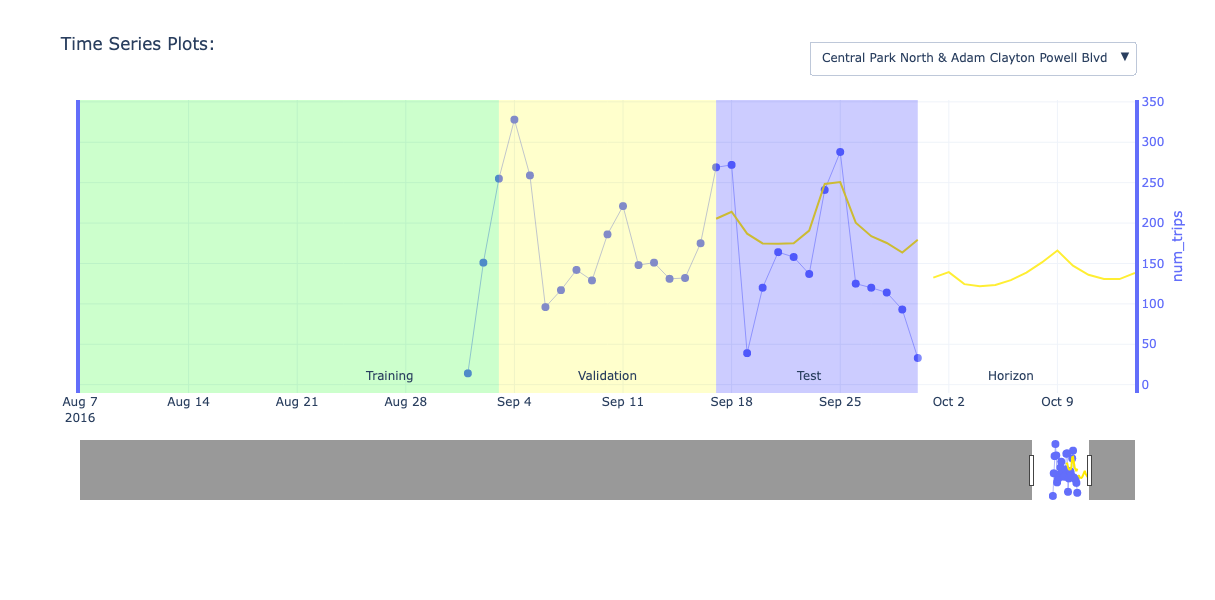

In [87]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] #+ COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = test_predictions[test_predictions[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = test_predictions[test_predictions[SERIES_COLUMN]==s][f'predicted_{TARGET_COLUMN}'],
                    name = f'Forecast: {v}',
                    text = test_predictions[test_predictions[SERIES_COLUMN]==s][f'predicted_{TARGET_COLUMN}'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            fig.add_trace(
                go.Scatter(
                    x = predict[predict[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = predict[predict[SERIES_COLUMN]==s][f'predicted_{TARGET_COLUMN}'],
                    name = f'Forecast: {v}',
                    text = predict[predict[SERIES_COLUMN]==s][f'predicted_{TARGET_COLUMN}'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 2 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

A Snapshot of the interactive plot:


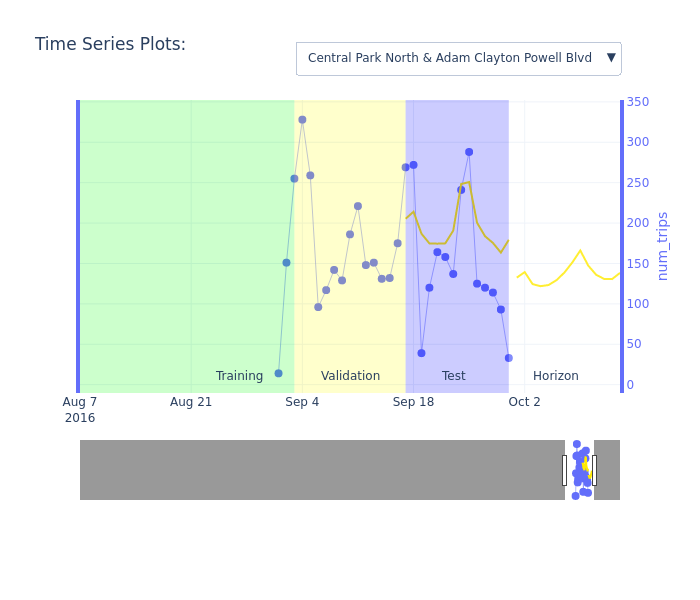

In [88]:
print('A Snapshot of the interactive plot:')
fig.show('png')

删除资源
请查看笔记本“99 - 清理”